# CNN demo

CPSC 340: Machine Learning and Data Mining

The University of British Columbia

2018 Winter Term 1

Mike Gelbart

Requires Keras to be installed:

```
pip install tensorflow
pip install keras
```

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from keras.applications.resnet50 import ResNet50, preprocess_input, decode_predictions
from keras.preprocessing import image

from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.layers.convolutional import Conv2D, Convolution2D, MaxPooling2D
from keras.datasets import mnist
from keras.utils import np_utils

Using TensorFlow backend.


Load a **pre-trained** 50-layer "residual network" trained on the ImageNet dataset.

In [2]:
model = ResNet50(weights='imagenet')

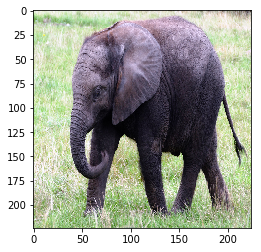

In [3]:
def prep_show_img(img_path):
    img = image.load_img(os.path.join("img", img_path), target_size=(224, 224))
    plt.imshow(img);
    return img
img = prep_show_img('elephant.jpg')

In [4]:
def predict(model, img):
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)

    preds = model.predict(x)
    return decode_predictions(preds, top=3)

predict(model, img)

[[('n02504458', 'African_elephant', 0.7131952),
  ('n01871265', 'tusker', 0.1770463),
  ('n02504013', 'Indian_elephant', 0.108073376)]]

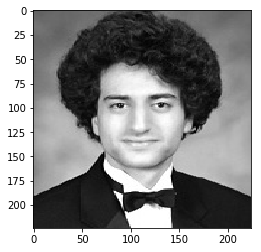

In [5]:
img = prep_show_img('gelbart-michael-adam.jpg')

In [6]:
predict(model, img)

[[('n02883205', 'bow_tie', 0.9872781),
  ('n03838899', 'oboe', 0.0047263713),
  ('n03110669', 'cornet', 0.0017303762)]]

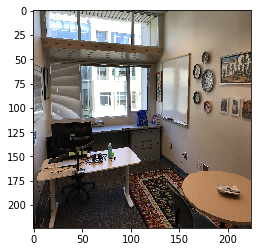

In [7]:
img = prep_show_img('office.jpg')

In [8]:
predict(model, img)

[[('n04005630', 'prison', 0.2949024),
  ('n03179701', 'desk', 0.0659849),
  ('n04239074', 'sliding_door', 0.046186645)]]

## Computation

Some nice things deep learning software can do for you:

- automatic differentiation
- compile/optimize code, especially for GPU 
- numerically stable implementations
- implementation of various regularizers (like dropout) and solvers (like Adam)
- a common standard for a community of users

## GPUs

- A big part of the deep learning revolution
- GPUs were originally designed for graphics --> _matrix multiplication_
  - This is what we need for neural networks
- Leader is NVIDIA, their GPU programming language is called CUDA.
  - These days we can usually avoid writing in CUDA
  - NVIDIA's share price 2 years ago: \$35. Now: \$220.
  
From Jeff Bezos' 2017 letter to shareholders:

> Using our pre-packaged versions of popular deep learning frameworks running on P2 compute instances (optimized for this workload), customers are already developing powerful systems ranging everywhere from early disease detection to increasing crop yields. [...] Watch this space. Much more to come.

- More recently: [P3 instances](https://aws.amazon.com/ec2/instance-types/p3/).

![](img/nvidia_ticker.png)

## Cloud computing

- CUDA-capable NVIDIA GPUs are [expensive](https://www.amazon.com/Nvidia-Tesla-GDDR5-Cores-Graphic/dp/B00Q7O7PQA). 
- Cloud computing platforms enable easy (and sometimes free) access. 
  - Big players are AWS EC2, Google Cloud, Microsoft Azure

## Demos

The data is built in to Keras, so we just access it for convenience. If not present already it is automatically downloaded.

Attribution: the code below is adapted from the [Keras MNIST example](https://github.com/fchollet/keras/blob/master/examples/mnist_mlp.py), which is under the [MIT license](https://github.com/fchollet/keras/blob/master/LICENSE).

In [9]:
# the data, shuffled and split between train and test sets
(X_train, y_train_cat), (X_test, y_test_cat) = mnist.load_data()

img_dim = (28,28) 
img_size = img_dim[0]*img_dim[1]
num_classes = 10

X_train = X_train.astype('float32')
X_test  = X_test.astype('float32')
X_train /= 255
X_test  /= 255
X_train_flat = X_train.reshape(60000, img_size)
X_test_flat  = X_test.reshape(10000, img_size)
X_train = X_train[...,None] # add 4th dimension, needed later for convnets
X_test  = X_test[...,None]

# convert class vectors to binary class matrices
y_train = np_utils.to_categorical(y_train_cat, num_classes)
y_test = np_utils.to_categorical(y_test_cat, num_classes)

print(X_train.shape[0], 'train samples')
print(X_test.shape[0], 'test samples')

60000 train samples
10000 test samples


## Demo 1: scikit-learn

In [10]:
from sklearn.neural_network import MLPClassifier

In [11]:
%%timeit -n1 -r1

nn = MLPClassifier(hidden_layer_sizes=(100,100), max_iter=10, 
                   batch_size=128)
nn.fit(X_train_flat, y_train_cat)

score = nn.score(X_train_flat, y_train_cat)
print('Train accuracy:', score)

score = nn.score(X_test_flat, y_test_cat)
print('Test accuracy:', score)

/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Train accuracy: 0.9946333333333334
Test accuracy: 0.9743
29.6 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


## Demo 2: Keras

### Fully-connected net

** Model definition **

Here we need to specify the input and output size in advance (unlike sklearn) because the model is first _compiled_.

In [12]:
model = Sequential()
model.add(Dense(100, input_shape=(X_train_flat.shape[1],), activation='relu'))
model.add(Dense(100, activation='relu'))
model.add(Dense(10, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

** Training and evaluation **

In [13]:
%%timeit -n1 -r1

history = model.fit(X_train_flat, y_train,
                    batch_size=128, 
                    epochs=10,
                    verbose=0)

score = model.evaluate(X_train_flat, y_train, verbose=0)
print('Train accuracy:', score[1])

score = model.evaluate(X_test_flat, y_test, verbose=0)
print('Test accuracy:', score[1])

Train accuracy: 0.9941333333333333
Test accuracy: 0.9769
24 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


### Convolutional net

Attribution: the code below is adapted from [Deep Learning with Python](https://machinelearningmastery.com/deep-learning-with-python2/) with permission from the author.

** Model definition **

In [14]:
model = Sequential()
model.add(Convolution2D(32, (5, 5), input_shape=img_dim+(1,), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(num_classes, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

** Training and evaluation **

In [15]:
%%timeit -n1 -r1

history = model.fit(X_train, y_train,
                    batch_size=128, 
                    epochs=1,
                    verbose=0)

score = model.evaluate(X_train, y_train, verbose=0)
print('Train accuracy:', score[1])

score = model.evaluate(X_test, y_test, verbose=0)
print('Test accuracy:', score[1])

Train accuracy: 0.9767
Test accuracy: 0.9758
1min 6s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


## Demo 3: Training in the cloud

Instructions:

- Go to https://colab.research.google.com/
- Make an account
- Upload notebook or create a new one
- Runtime --> change runtime type
- Select GPU

Typical speedups of **10x**. This translates into more prototyping, more optimization, better models.

## Model architecture and number of parameters

In [16]:
# define a simple CNN model
model = Sequential()
model.add(Conv2D(32, (5, 5), input_shape=(28, 28, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))
model.add(Conv2D(32, (5, 5), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))
model.add(Flatten())
model.add(Dense(10, activation='softmax'))

Can we account for all these parameters?

- The 1st convolutional layer has $5\times 5\times 3\times 32$ (+32 bias).
  - this results in images of size 24x24 (we're throwing away the boundaries) 
  - after 2x2 max pooling they are 12x12. 
- The 2nd convolutional layer has $5\times 5\times 32\times 32$ (+32 bias). 
  - this results in images of size 8x8 
  - after 2x2 max pooling they are 4x4. 
  - after flattening we have $4\times 4 \times 32 = 512$ units
- The fully connected layer has $512 \times 10$ (+10 bias).

Total numer of parameters: 

In [17]:
(5*5*3*32 + 32) + (5*5*32*32 + 32) + (512*10 + 10)

33194

We can confirm below:

In [18]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 24, 24, 32)        2432      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 12, 12, 32)        0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 12, 12, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 8, 8, 32)          25632     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 4, 4, 32)          0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 4, 4, 32)          0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 512)               0         
__________

If you understand the above calculation, you understand CNNs to a level _beyond_ what you need for CPSC 340. 

We'll actually train such a model next class. It's too slow on my laptop!